In [1]:
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import sys
import time
import shutil
sys.path.insert(0, '../..')

from database.dataset import INBreast_Dataset
from metrics.metrics_utils import get_tp_fp_fn_center_patch_criteria
from candidate_proposal.morphology_mc import MorphologyCalcificationDetection
from candidate_proposal.hdog_mc import HDoGCalcificationDetection
from candidate_proposal.hough_mc import HoughCalcificationDetection

from tqdm import tqdm
from numba.core.errors import NumbaDeprecationWarning, NumbaPendingDeprecationWarning
from pathlib import Path

import warnings
import seaborn as sns
warnings.simplefilter('ignore', category=NumbaDeprecationWarning)
warnings.simplefilter('ignore', category=NumbaPendingDeprecationWarning)

### Define experiment runers

Morphology

In [2]:
def run_experiment_gsm(threshold, min_distance, area, db, results_path, filter_muscle):
    normal_ids = db.get_free_of_selected_lesions_imgs_ids()

    m_results_path = results_path / 'morphology'
    m_results_path.mkdir(exist_ok=True, parents=True)

    rbd_path = m_results_path / 'recounstructed_by_dialation_img'
    if rbd_path.exists():
        shutil.rmtree(rbd_path)
    rbd_path.mkdir(exist_ok=True, parents=True)

    result_det = {}
    res = []
    for idx in tqdm(range(len(db)), total=len(db)):
        case = db[idx]
        image = case['img']
        image_id = case['img_id']
        lesion_mask = case['lesion_mask']
        if filter_muscle:
            muscle_mask = case['muscle_mask']

        md = MorphologyCalcificationDetection(
            rbd_path, threshold=threshold, min_distance=min_distance,
            area=area*area, store_intermediate=False, filter_muscle_region=filter_muscle)

        start = time.time()
        if filter_muscle:
            candidate_blobs = md.detect(image, image_id, muscle_mask)
        else:
            candidate_blobs = md.detect(image, image_id)
        t = time.time() - start

        tp, fp, fn, _ = get_tp_fp_fn_center_patch_criteria(
            candidate_blobs, lesion_mask, None, 14, use_euclidean_dist=True)
        tp_wo_duplicates = tp.drop_duplicates(subset=['matching_gt'], keep='first')
        img_res = {
            'img_id': image_id, 'TP': len(tp), 'TP_wo_dup': len(tp_wo_duplicates), 'FP': len(fp),
            'FN': len(fn), 'time': t, 'normal': image_id in normal_ids}

        res.append(img_res)
        result_det[image_id] = {
            'tp': tp.loc[:, ['x', 'y', 'radius']].values,
            'fp': fp.loc[:, ['x', 'y', 'radius']].values,
            'fn': fn.loc[:, ['x', 'y', 'radius']].values}
    results_morphology = pd.DataFrame(res)
    filename = f'md_th-{threshold}_mindist-{min_distance}_area-{area}'
    results_morphology.to_csv(results_path/f'{filename}.csv')
    with open(results_path/f'{filename}.pkl', 'wb') as f:
        pickle.dump(result_det, f)

HDoG

In [3]:
def run_experiment_hdog(dog_parameters, hessian_parameters, db, results_path, filter_muscle):
    
    normal_ids = db.get_free_of_selected_lesions_imgs_ids()
    
    hdog_results_path = results_path / 'HDoG'
    hdog_results_path.mkdir(exist_ok=True, parents=True)

    processed_imgs_path = hdog_results_path / 'hdog_images'
    if processed_imgs_path.exists():
        shutil.rmtree(processed_imgs_path)
    processed_imgs_path.mkdir(exist_ok=True, parents=True)

    detections_path = hdog_results_path / 'hdog_detections'
    if processed_imgs_path.exists():
        shutil.rmtree(processed_imgs_path)
    if detections_path.exists():
        shutil.rmtree(detections_path)
    detections_path.mkdir(exist_ok=True, parents=True)

    result_det = {}
    res = []

    for idx in tqdm(range(len(db)), total=len(db)):
        case = db[idx]
        image = case['img']
        image_id = case['img_id']
        lesion_mask = case['lesion_mask']
        if filter_muscle:
            muscle_mask = case['muscle_mask']

        hdogd = HDoGCalcificationDetection(
            dog_parameters, hessian_parameters, processed_imgs_path, detections_path,
            filter_muscle_region=filter_muscle)
        
        start = time.time()
        if filter_muscle:
            detections = hdogd.detect(image, image_id, False, False, muscle_mask)
        else:
            detections = hdogd.detect(image, image_id, False, False)
        t = time.time() - start

        tp, fp, fn, _ = get_tp_fp_fn_center_patch_criteria(
            detections, lesion_mask, None, 14, use_euclidean_dist=True)
        tp_wo_duplicates = tp.drop_duplicates(subset=['matching_gt'], keep='first')
        img_res = {
            'img_id': image_id, 'TP': len(tp), 'TP_wo_dup': len(tp_wo_duplicates), 'FP': len(fp),
            'FN': len(fn), 'time': t, 'normal': image_id in normal_ids}

        res.append(img_res)
        result_det[image_id] = {
            'tp': tp.loc[:, ['x', 'y', 'radius']].values,
            'fp': fp.loc[:, ['x', 'y', 'radius']].values,
            'fn': fn.loc[:, ['x', 'y', 'radius']].values}

    results_hdog = pd.DataFrame(res)

    ms = dog_parameters['min_sigma']
    Ms = dog_parameters['max_sigma']
    ns = dog_parameters['n_scales']
    ns = dog_parameters['n_scales']
    dth = dog_parameters['dog_blob_th']
    dovp = dog_parameters['dog_overlap']
    dmd = dog_parameters['dog_min_dist']
    filename = f'hdog_ms-{ms}_Ms-{Ms}_ns-{ns}_dth-{dth}_dovp-{dovp}_dmd-{dmd}'
    results_hdog.to_csv(results_path/f'{filename}.csv')
    with open(results_path/f'{filename}.pkl', 'wb') as f:
        pickle.dump(result_det, f)

Hough

In [4]:
def run_experiment_hough(
    dehazing_params, hough1_params, hough2_params, back_ext_radius,
    erosion_iter, erosion_size, min_hough2_distance, db, results_path, filter_muscle
):
    normal_ids = db.get_free_of_selected_lesions_imgs_ids()

    hough_results_path = results_path / 'Hough'
    hough_results_path.mkdir(exist_ok=True, parents=True)

    processed_imgs_path = hough_results_path / 'hough_images'
    if processed_imgs_path.exists():
        shutil.rmtree(processed_imgs_path)
    processed_imgs_path.mkdir(exist_ok=True, parents=True)

    result_det_h1 = {}
    result_det_h2 = {}
    res_h1 = []
    res_h2 = []

    for idx in tqdm(range(len(db)), total=len(db)):
        case = db[idx]
        image = case['img']
        image_id = case['img_id']
        lesion_mask = case['lesion_mask']
        if filter_muscle:
            muscle_mask = case['muscle_mask']

        hd = HoughCalcificationDetection(
            dehazing_params, back_ext_radius, processed_imgs_path, hough1_params, hough2_params,
            erosion_iter=erosion_iter, erosion_size=erosion_size, min_hough2_dist=min_hough2_distance,
            filter_muscle_region=filter_muscle)

        start = time.time()
        if filter_muscle:
            h1_circles, h2_circles = hd.detect(image, image_id,
                load_processed_images=False, hough2=True, muscle_mask=muscle_mask)
        else:
            h1_circles, h2_circles = hd.detect(image, image_id,
                load_processed_images=False, hough2=True)
        t = time.time() - start

        tp, fp, fn, _ = get_tp_fp_fn_center_patch_criteria(h1_circles, lesion_mask, None, 14, use_euclidean_dist=True)
        result_det_h1[image_id] = {
            'tp': tp.loc[:, ['x', 'y', 'radius']].values,
            'fp': fp.loc[:, ['x', 'y', 'radius']].values,
            'fn': fn.loc[:, ['x', 'y', 'radius']].values}
        tp_wo_duplicates = tp.drop_duplicates(subset=['matching_gt'], keep='first')
        img_res_h1 = {
            'img_id': image_id, 'TP': len(tp), 'TP_wo_dup': len(tp_wo_duplicates), 'FP': len(fp),
            'FN': len(fn), 'time': t, 'normal': image_id in normal_ids}
        res_h1.append(img_res_h1)

        tp, fp, fn, _ = get_tp_fp_fn_center_patch_criteria(h2_circles, lesion_mask, None, 14, use_euclidean_dist=True)
        result_det_h2[image_id] = {
            'tp': tp.loc[:, ['x', 'y', 'radius']].values,
            'fp': fp.loc[:, ['x', 'y', 'radius']].values,
            'fn': fn.loc[:, ['x', 'y', 'radius']].values}
        tp_wo_duplicates = tp.drop_duplicates(subset=['matching_gt'], keep='first')
        img_res_h2 = {
            'img_id': image_id, 'TP': len(tp), 'TP_wo_dup': len(tp_wo_duplicates), 'FP': len(fp),
            'FN': len(fn), 'time': t, 'normal': image_id in normal_ids}
        res_h2.append(img_res_h2)

    results_hough_h1 = pd.DataFrame(res_h1)
    results_hough_h2 = pd.DataFrame(res_h2)

    filename = f'hough_default'
    results_hough_h1.to_csv(results_path/f'{filename}_h1.csv')
    with open(results_path/f'{filename}_h1.pkl', 'wb') as f:
        pickle.dump(result_det_h1, f)

    results_hough_h2.to_csv(results_path/f'{filename}_h2.csv')
    with open(results_path/f'{filename}_h2.pkl', 'wb') as f:
        pickle.dump(result_det_h2, f)

In [63]:
def plot_results(results_path):
    filename = 'md_th-0.95_mindist-6_area-14'
    results_morphology95 = pd.read_csv(results_path/f'{filename}.csv', index_col=0)
    results_morphology95['method'] = 'gs_morph_095'

    filename = 'md_th-0.97_mindist-6_area-14'
    results_morphology = pd.read_csv(results_path/f'{filename}.csv', index_col=0)
    results_morphology['method'] = 'gs_morph_097'

    filename = 'hdog_ms-1_Ms-3_ns-20_dth-0.006_dovp-0.2_dmd-6'#'hdog_ms-1_Ms-3_ns-20_dth-0.006_dmd-6'
    results_hdog = pd.read_csv(results_path/f'{filename}.csv', index_col=0)
    results_hdog['method'] = 'hdog'

    results_hough_h1 = pd.read_csv(results_path/'hough_default_h1.csv', index_col=0)
    results_hough_h1['method'] = 'hough_h1'
    results_hough_h2 = pd.read_csv(results_path/'hough_default_h2.csv', index_col=0)
    results_hough_h2['method'] = 'hough_h2'

    results = pd.concat([results_morphology95, results_morphology, results_hdog, results_hough_h1, results_hough_h2], ignore_index=True)
    results['FPR'] = results['FP'] / (results['FP'] + results['TP'])
    results['mfpi'] = (results['FP'] / len(results)).sum()
    results['sens'] = results['TP'] / (results['TP'] + results['FN'])
    results['sens_wod'] = results['TP_wo_dup'] / (results['TP_wo_dup'] + results['FN'])
    results.loc[~results.normal, 'fp_per_tp'] = results['FP'] / (results['TP'])
    results.loc[(~results.normal) & (results.sens==0), 'fp_per_tp'] = results['FP']
    results.loc[results.normal, 'fp_per_tp'] = results['FP']

    melt_results = pd.melt(results, id_vars=['method'], value_vars=['sens', 'sens_wod'])

    plt.figure(figsize=(10, 4))
    plt.title('Sensitivity vs method')
    sns.boxplot(data=results, x='method', y='sens')
    sns.despine()
    plt.show()
    
    plt.figure(figsize=(10, 4))
    plt.title('Sensitivity wo_d vs method')
    sns.boxplot(data=results, x='method', y='sens_wod')
    sns.despine()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title('Sensitivity comparison')
    sns.boxplot(data=melt_results, x='method', y='value', hue='variable')
    sns.despine()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title('False positives per tp per image vs method')
    sns.boxplot(data=results, x='method', y='fp_per_tp')
    plt.ylim(0, 2000)
    sns.despine()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title('False positives per tp per image vs method')
    sns.boxplot(data=results, x='method', y='fp_per_tp')
    plt.yscale('log')
    sns.despine()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title('False positives per image on normal images vs method')
    sns.boxplot(data=results.loc[results.normal], x='method', y='fp_per_tp')
    plt.ylim(0, 25000)
    sns.despine()
    plt.show()

    plt.figure(figsize=(10, 4))
    plt.title('Computation time per image vs method')
    sns.boxplot(data=results, x='method', y='time')
    # plt.yscale('log')
    sns.despine()
    plt.ylabel('time [s]')
    plt.ylim([0, 70])
    plt.show()
    
    return results_morphology95, results_morphology, results_hdog, results_hough_h1, results_hough_h2


## Run experiments without pectoral supression and with circular labelling

In [5]:
db = INBreast_Dataset(
    return_lesions_mask=True,
    level='image',
    max_lesion_diam_mm=None,
    extract_patches=False,
    partitions = ['train', 'validation'],
    lesion_types = ['calcification', 'cluster'],
    cropped_imgs = True,
    keep_just_images_of_lesion_type = False,
    use_muscle_mask=False,
    ignore_diameter_px = 15
)

In [11]:
results_path = Path.cwd().parent.parent.parent / 'data/comparisson_between_detectors_w_pectoral/'
results_path.mkdir(exist_ok=True, parents=True)

In [ ]:

# # GSM
# threshold = 0.97
# min_distance = 6
# area = 14
# run_experiment_gsm(threshold, min_distance, area, db, results_path, filter_muscle=False)

# threshold = 0.95
# min_distance = 6
# area = 14
# run_experiment_gsm(threshold, min_distance, area, db, results_path, filter_muscle=False)


# # HDOG
# dog_parameters = {
#     'min_sigma': 1,
#     'max_sigma': 3,
#     'n_scales': 20,
#     'sigma_ratio': None,
#     'dog_blob_th': 0.006,
#     'dog_overlap': 0.2,
#     'dog_min_dist': 6,
# }

# hessian_parameters = {
#     'method': 'eigenval',
#     'hessian_threshold': None,
#     'hessian_th_divider': 300
# }

# run_experiment_hdog(dog_parameters, hessian_parameters, db, results_path, filter_muscle=False)



# HOUGH

dehazing_params = {'omega': 0.9, 'window_size': 11, 'radius': 40, 'eps': 1e-5}

hough1_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 10,
                 'param1': 300, 'param2': 5,  'minRadius': 2, 'maxRadius': 10}
hough2_params = {'method': cv2.HOUGH_GRADIENT, 'dp': 1, 'minDist': 20,
                 'param1': 300, 'param2': 3,  'minRadius': 2, 'maxRadius': 10}

back_ext_radius = 50
erosion_iter = 20
erosion_size = 5
min_hough2_distance = 6
run_experiment_hough(
    dehazing_params, hough1_params, hough2_params, back_ext_radius, erosion_iter,
    erosion_size, min_hough2_distance, db, results_path, filter_muscle=False
)


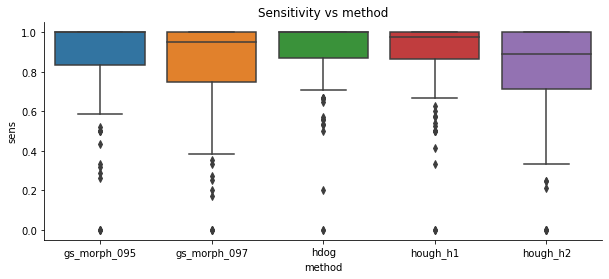

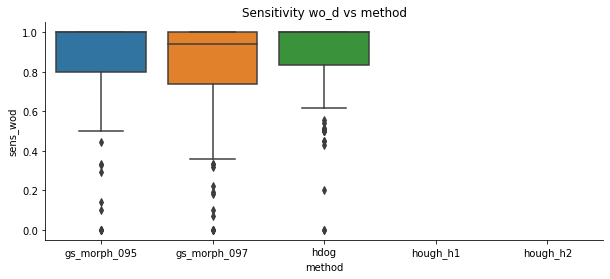

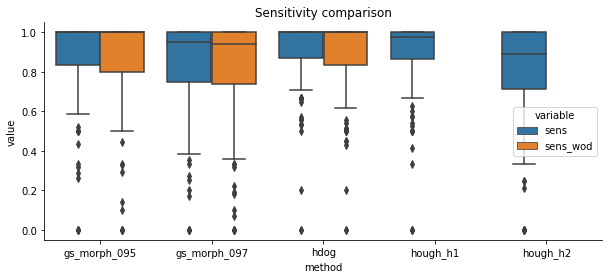

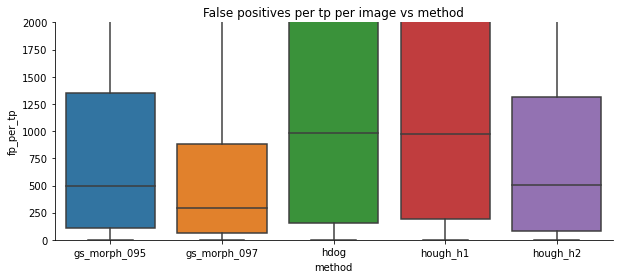

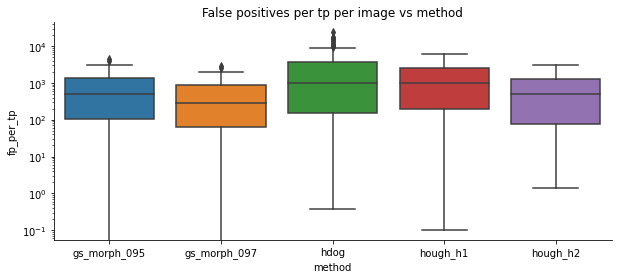

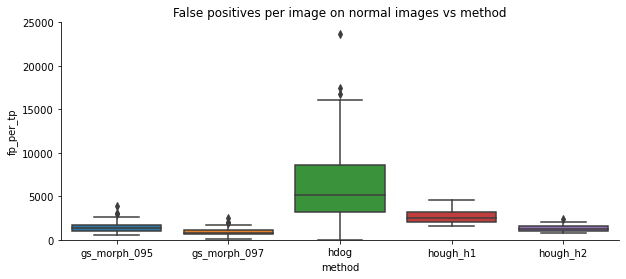

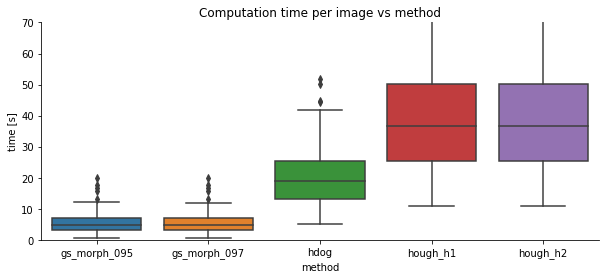

In [64]:
# RESULTS
# remove normals from comparison (they would be sensitivity outliers)
normal_imgs_ids = db.get_normal_imgs_ids()

results_morphology95, results_morphology, results_hdog, results_hough_h1, results_hough_h2 = plot_results(results_path)

### Looking into badly detected images

In [65]:
merged_res = pd.concat([results_morphology95, results_morphology, results_hdog, results_hough_h1, results_hough_h2])
merged_res

img_id  TP  TP_wo_dup    FP  FN       time  normal        method
0    20587054   0        0.0  1045   0   2.331956   False  gs_morph_095
1    20587080   0        0.0  1598   0   5.027766   False  gs_morph_095
2    20587148   4        2.0   665   0   1.470703   False  gs_morph_095
3    20587174  12       10.0   341   0   1.268461   False  gs_morph_095
4    20587200   4        4.0  1234   0   4.696390   False  gs_morph_095
..        ...  ..        ...   ...  ..        ...     ...           ...
205  53586896   4        NaN  2931   0  75.724212   False      hough_h2
206  53587427   2        NaN  1736   0  43.526721   False      hough_h2
207  53587454   3        NaN  1909   0  47.997442   False      hough_h2
208  53587481   7        NaN  1355   1  27.768285   False      hough_h2
209  53587508   1        NaN  1618   0  37.795495   False      hough_h2

[1050 rows x 8 columns]

### Images in which we haven't detected any calcificaitons, though some were present

In [100]:
not_detected_imgs = merged_res[(merged_res.TP == 0)&(merged_res.FN != 0)].groupby('img_id')['method'].count().sort_values(ascending=False)
not_detected_imgs

img_id
20587320    4
26933772    4
26933830    4
53582422    4
53582476    1
53586805    1
Name: method, dtype: int64

img_id  TP  TP_wo_dup    FP  FN       time  normal        method  \
7  20587320   0        0.0  1489   5   5.212154   False  gs_morph_095   
7  20587320   0        0.0   907   5   5.790713   False  gs_morph_097   
7  20587320   1        1.0  1670   4  16.211072   False          hdog   
7  20587320   0        NaN  3081   5  39.220714   False      hough_h1   
7  20587320   0        NaN  1451   5  39.220714   False      hough_h2   

   sens_wod  
7       0.0  
7       0.0  
7       0.2  
7       NaN  
7       NaN

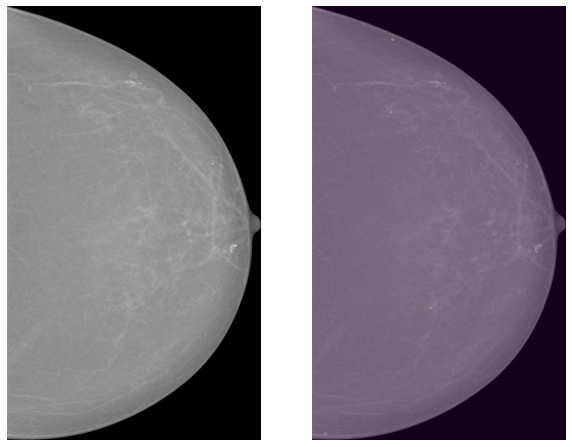

img_id  TP  TP_wo_dup    FP  FN       time  normal        method  \
91  26933772   0        0.0   366   2   0.702614   False  gs_morph_095   
91  26933772   0        0.0   208   2   0.695062   False  gs_morph_097   
91  26933772   0        0.0  1780   2   5.161522   False          hdog   
91  26933772   1        NaN  1047   1  10.864349   False      hough_h1   
91  26933772   0        NaN   495   2  10.864349   False      hough_h2   

    sens_wod  
91       0.0  
91       0.0  
91       0.0  
91       NaN  
91       NaN

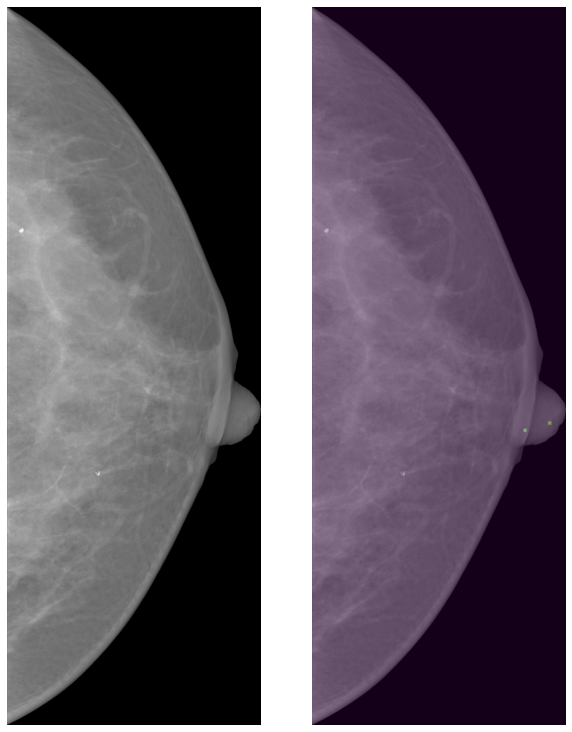

img_id  TP  TP_wo_dup    FP  FN       time  normal        method  \
93  26933830   0        0.0   678   1   1.238285   False  gs_morph_095   
93  26933830   0        0.0   450   1   1.227229   False  gs_morph_097   
93  26933830   1        1.0  3487   0   7.518486   False          hdog   
93  26933830   0        NaN  1584   1  16.429100   False      hough_h1   
93  26933830   0        NaN   702   1  16.429100   False      hough_h2   

    sens_wod  
93       0.0  
93       0.0  
93       1.0  
93       NaN  
93       NaN

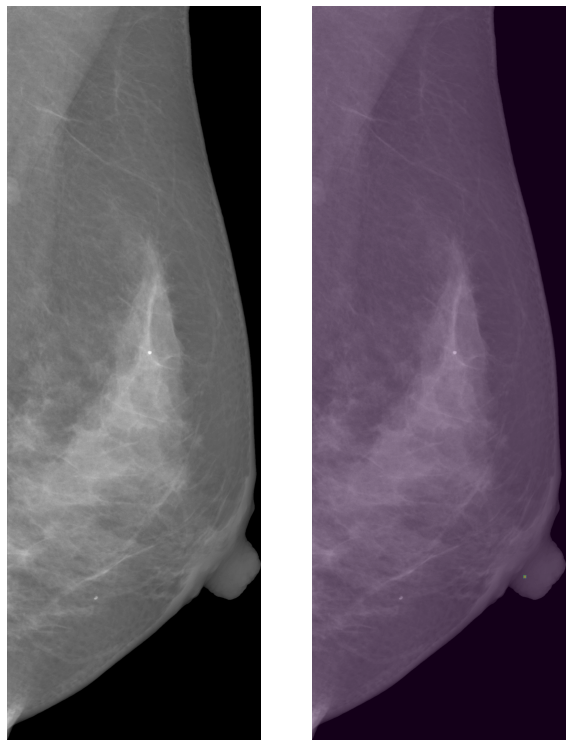

img_id  TP  TP_wo_dup     FP  FN       time  normal        method  \
188  53582422   0        0.0   1756   1   3.196033   False  gs_morph_095   
188  53582422   0        0.0   1170   1   3.147715   False  gs_morph_097   
188  53582422   1        1.0  10903   0  18.909691   False          hdog   
188  53582422   0        NaN   2706   1  32.241686   False      hough_h1   
188  53582422   0        NaN   1325   1  32.241686   False      hough_h2   

     sens_wod  
188       0.0  
188       0.0  
188       1.0  
188       NaN  
188       NaN

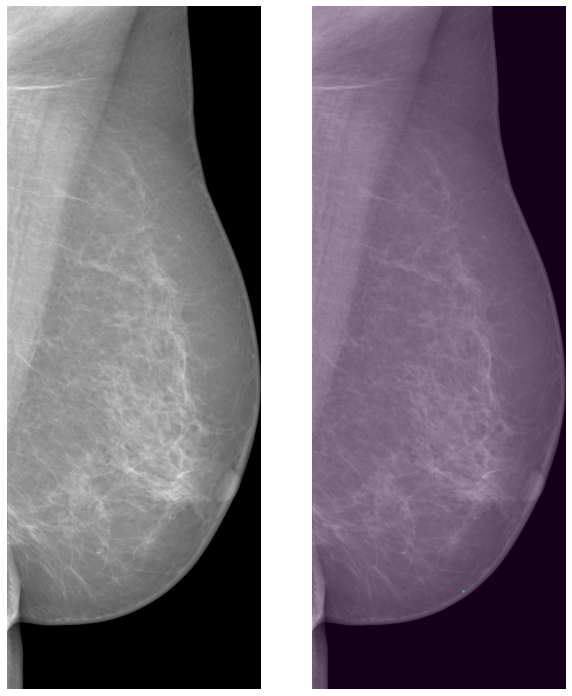

img_id  TP  TP_wo_dup    FP  FN       time  normal        method  \
190  53582476   1        1.0  1138   0   2.205390   False  gs_morph_095   
190  53582476   1        1.0   690   0   2.170159   False  gs_morph_097   
190  53582476   1        1.0  5326   0  12.726139   False          hdog   
190  53582476   1        NaN  2125   0  22.155568   False      hough_h1   
190  53582476   0        NaN  1075   1  22.155568   False      hough_h2   

     sens_wod  
190       1.0  
190       1.0  
190       1.0  
190       NaN  
190       NaN

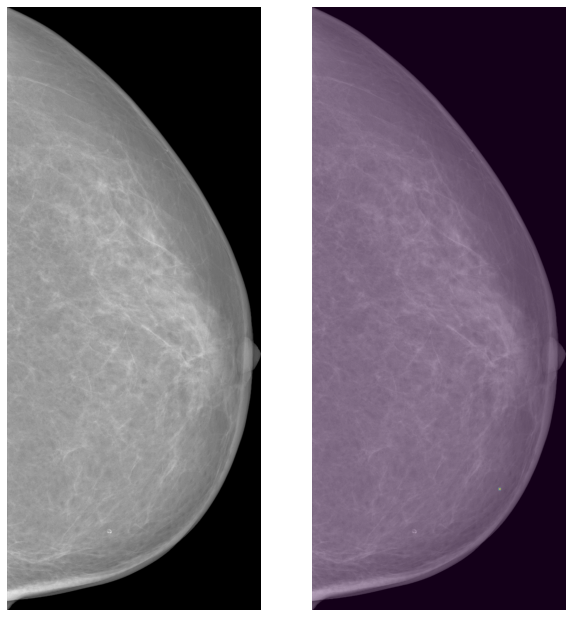

In [101]:
for imgid in not_detected_imgs.index[:5]:
    display(merged_res[merged_res.img_id == imgid])
    idx = db.df[db.df.img_id == imgid].index.values[0]
    img = db[idx]['img']
    mask = db[idx]['lesion_mask']

    plt.figure(figsize=(10,25))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.subplot(122)
    mask = cv2.dilate(mask, kernel=np.ones((11,11)))
    plt.imshow(img, cmap='gray')
    plt.imshow(mask>0, alpha=0.3)
    plt.axis('off')
    plt.show()

### Images for which we didn't have labels

In [102]:
not_detected_imgs = merged_res[(merged_res.TP == 0)&(merged_res.FN == 0)].groupby('img_id')['method'].count().sort_values(ascending=False)
not_detected_imgs

img_id
20587054    5
50996325    5
50996379    5
50996406    5
50997053    5
           ..
50994760    5
50994787    5
50994814    5
50994868    5
53586751    5
Name: method, Length: 61, dtype: int64

img_id  TP  TP_wo_dup    FP  FN       time  normal        method  \
0  20587054   0        0.0  1045   0   2.331956   False  gs_morph_095   
0  20587054   0        0.0   639   0   2.922988   False  gs_morph_097   
0  20587054   0        0.0  6044   0  13.322011   False          hdog   
0  20587054   0        NaN  2441   0  29.808561   False      hough_h1   
0  20587054   0        NaN  1198   0  29.808561   False      hough_h2   

   sens_wod  
0       NaN  
0       NaN  
0       NaN  
0       NaN  
0       NaN

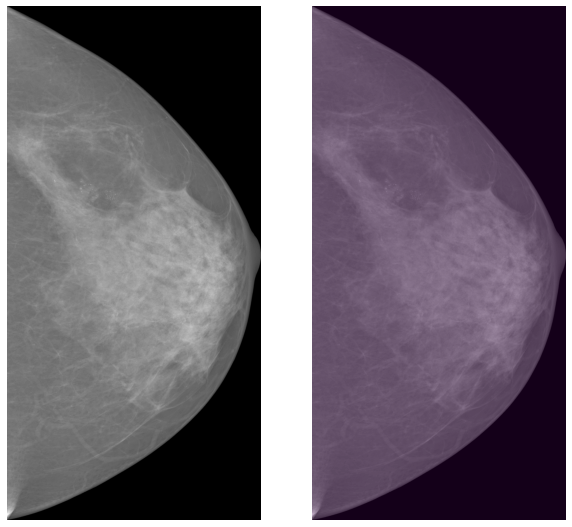

img_id  TP  TP_wo_dup    FP  FN       time  normal        method  \
139  50996325   0        0.0  1656   0   5.004203    True  gs_morph_095   
139  50996325   0        0.0  1021   0   4.866025    True  gs_morph_097   
139  50996325   0        0.0  2890   0  16.487270    True          hdog   
139  50996325   0        NaN  2097   0  22.872857    True      hough_h1   
139  50996325   0        NaN  1049   0  22.872857    True      hough_h2   

     sens_wod  
139       NaN  
139       NaN  
139       NaN  
139       NaN  
139       NaN

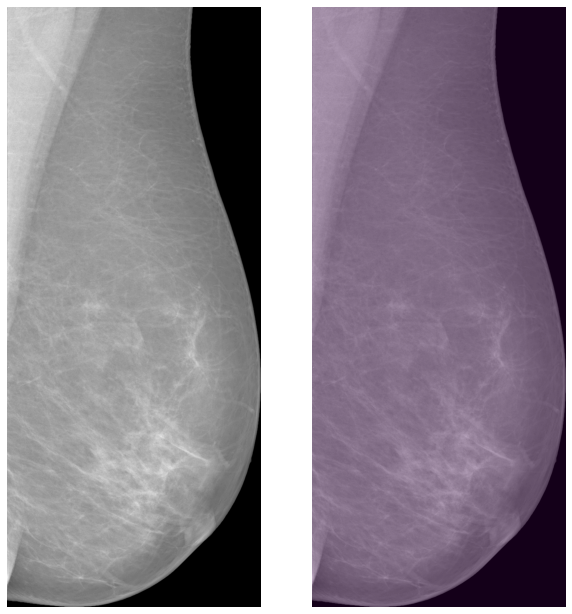

img_id  TP  TP_wo_dup    FP  FN       time  normal        method  \
141  50996379   0        0.0  1048   0   2.728917    True  gs_morph_095   
141  50996379   0        0.0   679   0   2.745907    True  gs_morph_097   
141  50996379   0        0.0  5163   0  11.647732    True          hdog   
141  50996379   0        NaN  1896   0  18.431280    True      hough_h1   
141  50996379   0        NaN   919   0  18.431280    True      hough_h2   

     sens_wod  
141       NaN  
141       NaN  
141       NaN  
141       NaN  
141       NaN

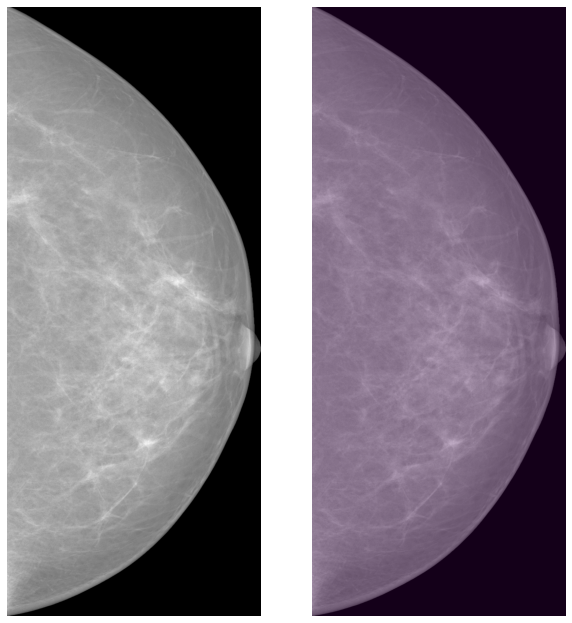

img_id  TP  TP_wo_dup    FP  FN       time  normal        method  \
142  50996406   0        0.0  1000   0   2.880774    True  gs_morph_095   
142  50996406   0        0.0   664   0   2.890135    True  gs_morph_097   
142  50996406   0        0.0  4856   0  10.761396    True          hdog   
142  50996406   0        NaN  1613   0  17.012780    True      hough_h1   
142  50996406   0        NaN   839   0  17.012780    True      hough_h2   

     sens_wod  
142       NaN  
142       NaN  
142       NaN  
142       NaN  
142       NaN

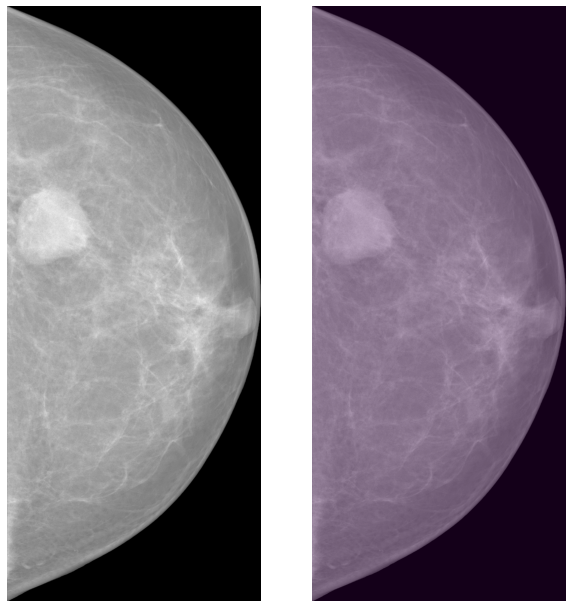

img_id  TP  TP_wo_dup    FP  FN       time  normal        method  \
149  50997053   0        0.0  1374   0   3.745425    True  gs_morph_095   
149  50997053   0        0.0   862   0   3.727597    True  gs_morph_097   
149  50997053   0        0.0  8590   0  19.016586    True          hdog   
149  50997053   0        NaN  3314   0  42.386861    True      hough_h1   
149  50997053   0        NaN  1500   0  42.386861    True      hough_h2   

     sens_wod  
149       NaN  
149       NaN  
149       NaN  
149       NaN  
149       NaN

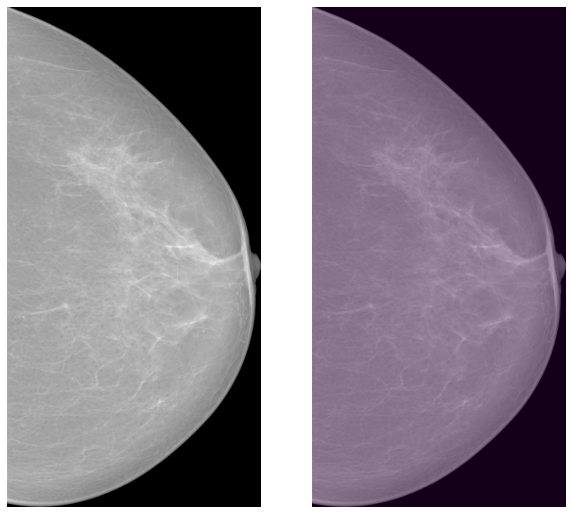

In [103]:
for imgid in not_detected_imgs.index[:5]:
    display(merged_res[merged_res.img_id == imgid])
    idx = db.df[db.df.img_id == imgid].index.values[0]
    img = db[idx]['img']
    mask = db[idx]['lesion_mask']

    plt.figure(figsize=(10,25))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.subplot(122)
    mask = cv2.dilate(mask, kernel=np.ones((11,11)))
    plt.imshow(img, cmap='gray')
    plt.imshow(mask>0, alpha=0.3)
    plt.axis('off')
    plt.show()

### Images with low sensitivity (but with mC)

In [104]:
merged_res

img_id  TP  TP_wo_dup    FP  FN       time  normal        method  \
0    20587054   0        0.0  1045   0   2.331956   False  gs_morph_095   
1    20587080   0        0.0  1598   0   5.027766   False  gs_morph_095   
2    20587148   4        2.0   665   0   1.470703   False  gs_morph_095   
3    20587174  12       10.0   341   0   1.268461   False  gs_morph_095   
4    20587200   4        4.0  1234   0   4.696390   False  gs_morph_095   
..        ...  ..        ...   ...  ..        ...     ...           ...   
205  53586896   4        NaN  2931   0  75.724212   False      hough_h2   
206  53587427   2        NaN  1736   0  43.526721   False      hough_h2   
207  53587454   3        NaN  1909   0  47.997442   False      hough_h2   
208  53587481   7        NaN  1355   1  27.768285   False      hough_h2   
209  53587508   1        NaN  1618   0  37.795495   False      hough_h2   

     sens_wod  
0         NaN  
1         NaN  
2         1.0  
3         1.0  
4         1.0  
..        ...  
205       NaN  
206       NaN  
207       NaN  
208       NaN  
209       NaN  

[1050 rows x 9 columns]

In [105]:
not_detected_imgs = merged_res[merged_res.sens_wod <= 0.5].groupby('img_id')['method'].count().sort_values(ascending=False)
not_detected_imgs

img_id
50996709    3
50993949    3
50993841    3
20587320    3
26933772    3
50993697    2
51048972    2
50993895    2
50993868    2
50993787    2
50993670    2
26933830    2
24065680    2
53582422    2
53582737    2
20587346    2
50996999    1
53582683    1
53582791    1
20587294    1
50993814    1
50993976    1
24065557    1
24055806    1
22670301    1
20587784    1
53586805    1
Name: method, dtype: int64

img_id  TP  TP_wo_dup    FP  FN       time  normal        method  \
143  50996709   1        1.0  1833   1   5.203018   False  gs_morph_095   
143  50996709   1        1.0  1093   1   5.166445   False  gs_morph_097   
143  50996709   2        1.0  2464   1  23.151153   False          hdog   
143  50996709   2        NaN  3696   0  48.462466   False      hough_h1   
143  50996709   2        NaN  1729   0  48.462466   False      hough_h2   

     sens_wod  
143       0.5  
143       0.5  
143       0.5  
143       NaN  
143       NaN

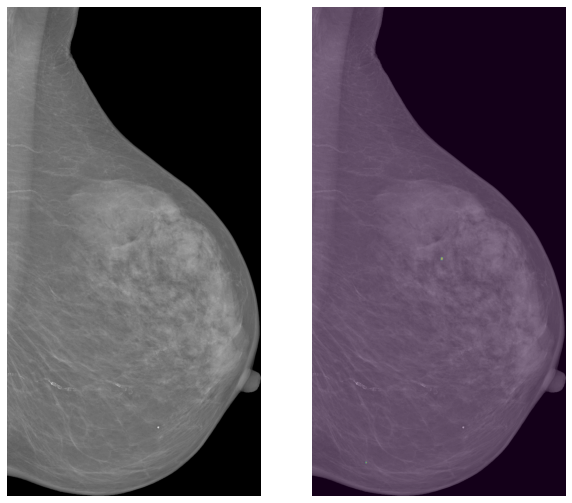

img_id   TP  TP_wo_dup  FP   FN       time  normal        method  \
117  50993949   35       11.0   0   98   2.043039   False  gs_morph_095   
117  50993949   21        8.0   0  101   2.048873   False  gs_morph_097   
117  50993949  118       49.0  50   60   9.530309   False          hdog   
117  50993949   87        NaN  10   78  18.986440   False      hough_h1   
117  50993949   32        NaN  64   96  18.986440   False      hough_h2   

     sens_wod  
117  0.100917  
117  0.073394  
117  0.449541  
117       NaN  
117       NaN

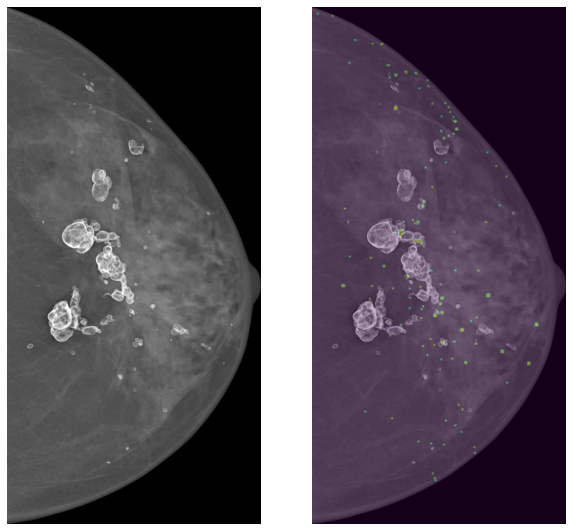

img_id   TP  TP_wo_dup  FP  FN       time  normal        method  \
113  50993841   37       15.0   0  92   2.573530   False  gs_morph_095   
113  50993841   24       11.0   0  96   2.526951   False  gs_morph_097   
113  50993841  119       48.0  44  59  10.483066   False          hdog   
113  50993841   99        NaN  10  72  22.048751   False      hough_h1   
113  50993841   47        NaN  65  92  22.048751   False      hough_h2   

     sens_wod  
113  0.140187  
113  0.102804  
113  0.448598  
113       NaN  
113       NaN

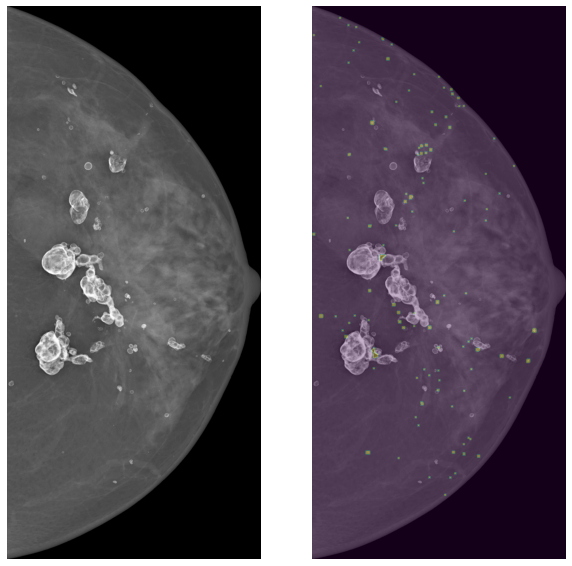

img_id  TP  TP_wo_dup    FP  FN       time  normal        method  \
7  20587320   0        0.0  1489   5   5.212154   False  gs_morph_095   
7  20587320   0        0.0   907   5   5.790713   False  gs_morph_097   
7  20587320   1        1.0  1670   4  16.211072   False          hdog   
7  20587320   0        NaN  3081   5  39.220714   False      hough_h1   
7  20587320   0        NaN  1451   5  39.220714   False      hough_h2   

   sens_wod  
7       0.0  
7       0.0  
7       0.2  
7       NaN  
7       NaN

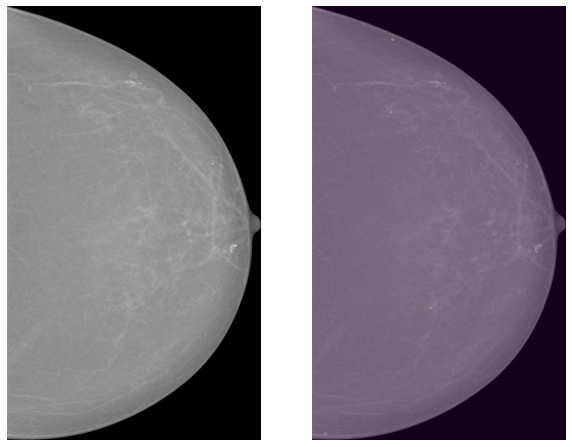

img_id  TP  TP_wo_dup    FP  FN       time  normal        method  \
91  26933772   0        0.0   366   2   0.702614   False  gs_morph_095   
91  26933772   0        0.0   208   2   0.695062   False  gs_morph_097   
91  26933772   0        0.0  1780   2   5.161522   False          hdog   
91  26933772   1        NaN  1047   1  10.864349   False      hough_h1   
91  26933772   0        NaN   495   2  10.864349   False      hough_h2   

    sens_wod  
91       0.0  
91       0.0  
91       0.0  
91       NaN  
91       NaN

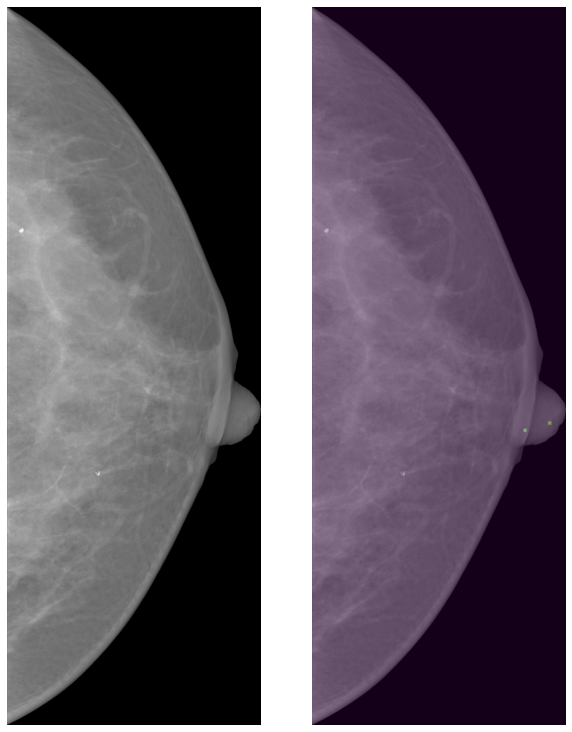

In [107]:
for imgid in not_detected_imgs.index[:5]:
    display(merged_res[merged_res.img_id == imgid])
    idx = db.df[db.df.img_id == imgid].index.values[0]
    img = db[idx]['img']
    mask = db[idx]['lesion_mask']

    plt.figure(figsize=(10,25))
    plt.subplot(121)
    plt.imshow(img, cmap='gray')
    plt.axis('off')
    plt.subplot(122)
    mask = cv2.dilate(mask, kernel=np.ones((11,11)))
    plt.imshow(img, cmap='gray')
    plt.imshow(mask>0, alpha=0.3)
    plt.axis('off')
    plt.show()